In [81]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
from scipy import signal
%run StreamClass.ipynb

## Plot each variable on a graph

In [87]:
data = Data_Stream("data5.csv")
print(data.acc_DRC.shape)
# data.plot()

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
(4760, 4)


## Kalman Filter Implementation

In [90]:
def getQ(acc_stddev, dt):
    vel_stddev = acc_stddev*dt
    dis_stddev = 0.5*acc_stddev*dt**2
    Q = (dis_stddev**2)*np.identity(4)
    Q[2, 2] = vel_stddev**2
    Q[3, 3] = vel_stddev**2
    Q[0, 2] = dis_stddev*vel_stddev
    Q[1, 3] = dis_stddev*vel_stddev
    return Q

def getFkBk(Fk, Bk, dt):
    Fk[0, 2] = dt
    Fk[1, 3] = dt
    Bk[0, 0] = 0.5*dt**2
    Bk[1, 1] = 0.5*dt**2
    Bk[2, 0] = dt
    Bk[3, 1] = dt
    return Fk, Bk

def kalman_predict(dt, Fk, Bk, xk, uk, Pk, acc_stddev):
    Q = getQ(acc_stddev, dt)
    Fk, Bk = getFkBk(Fk, Bk, dt)
    xk = np.matmul(Fk, xk) + np.matmul(Bk, uk)
    Pk = np.matmul(np.matmul(Fk, Pk), Fk.T) + Q
    return xk, Pk, Fk, Bk

def kalman_gain(Pk, H, R):
    PkHT = np.matmul(Pk, H.T)
    K = np.matmul(PkHT, np.linalg.inv(np.matmul(H, PkHT)+R))
    return K

def kalman_update_state(xk, zk, K, H):
    Hxk = np.matmul(H, xk)
    zk = np.concatenate((zk, np.asmatrix([0])))
    zk = np.concatenate((zk, np.asmatrix([0])))
    return xk+np.matmul(K, zk-Hxk )

def kalman_update_uncertainty(Pk, K, H):
    return Pk - np.matmul(K, np.matmul(H, Pk))

def reverse_data(acc, gps):
    
    end_time = acc[-1, 0]
    acc = acc[::-1]
    gps = gps[::-1]
    
    for i in range(len(acc)):
        acc[i] = -1*acc[i]
        acc[i, 0] += end_time
        gps[i, 0] = acc[i, 0]
        
    return acc, gps

def compute_kalman(data, reverse=False):
    ## Assume that the initial state is position (0, 0) and velocity (0, 0)       
    acc = data.acc_ERC
    gps = data.gps
    
    if(reverse):
        acc, gps = reverse_data(acc, gps)

    x0 = np.asmatrix([gps[0, 1], gps[0, 2], 0, 0]).T
    xks = [x0]
    u0 = acc[0, 1:3].T
    uks = [u0]
    Fk = np.asmatrix(np.identity(4))
    Bk = np.zeros((4, 2))

    acc_stddev = 0.6

    P0 = np.zeros((4, 4))
    Pks = [P0]

    H = np.identity(4)
    H[2, 2] = 0.0
    H[3, 3] = 0.0
    gps_var = 15.2
    R = gps_var*np.identity(4)
    
    for i in range(1, acc.shape[0]):
        dt = acc[i, 0] - acc[i-1, 0]
        xk, Pk, Fk, Bk = kalman_predict(dt, Fk, Bk, xks[-1], uks[-1], Pks[-1], acc_stddev)
        xks.append(xk)
        uks.append(acc[i, 1:3].T)
        Pks.append(Pk)
        zk = gps[i, 1:3].T

        K = kalman_gain(Pks[-1], H, R)
        xks[-1] = kalman_update_state(xk, zk, K, H)
        Pks[-1] = kalman_update_uncertainty(Pks[-1], K, H)
        
    xks = [xk.T for xk in xks]
    xks = np.concatenate(xks)
    data.init_kalman(xks, reverse)

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


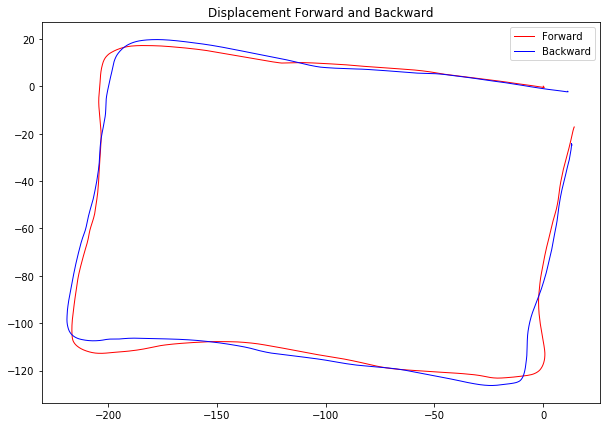

In [91]:
data = Data_Stream("data5.csv", load_truth=True)
compute_kalman(data)
compute_kalman(data, reverse=True)


plt.figure(figsize=(10, 7))
ax=plt.subplot(111)
plt.plot(data.kal_dis[:, 1], data.kal_dis[:, 2], 'r-', lw=1, label='Forward')
plt.plot(data.kal_dis_reverse[:, 1], data.kal_dis_reverse[:, 2], 'b-', lw=1, label='Backward')
plt.title("Displacement Forward and Backward") 
ax.legend()

Plot Kalman Filter output against original Sensor Input

## Plotting Overlay on Google Maps
https://www.geeksforgeeks.org/python-plotting-google-map-using-gmplot-package/

https://github.com/pbugnion/gmaps

https://jupyter-gmaps.readthedocs.io/en/latest/

In [79]:
import gmaps
import gmaps.datasets

f = open('apikey.txt')
a = f.readline()

gmaps.configure(api_key=a) # Your Google API key

f_layout = {'width': '900px','height': '800px','border': '1px solid black', 'padding': '1px'}
fig = gmaps.figure(layout = f_layout, center=(data.kal_latlng[0, 2], 
                                              data.kal_latlng[0, 1]), zoom_level=18, map_type='HYBRID')
lines = []

locations_kal = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.kal_latlng])
locations_kal.gradient = [(0, 0, 0, 0.0), (0, 255, 0, 1), (0, 128, 0, 1)]
locations_kal.max_intensity = 10
locations_kal.point_radius = 5

locations_kal_rev = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.kal_latlng_reverse])
locations_kal_rev.gradient = [(0, 0, 0, 0.0), (255, 0, 255, 1), (170, 0, 170, 1)]
locations_kal_rev.max_intensity = 10
locations_kal_rev.point_radius = 5

locations_gps = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.gps_latlng])
locations_gps.gradient = [(0, 0, 0, 0.0), (255, 0, 0, 1), (128, 0, 0 , 1)]
locations_gps.max_intensity = 10
locations_gps.point_radius = 5

# locations_gt = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.ground_truth.gps])
# locations_gt.gradient = [(0, 0, 0, 0.0), (0, 0, 255, 1), (0, 0, 128 , 1)]
# locations_gt.max_intensity = 20
# locations_gt.point_radius = 5

# Features to draw on the map
gt_lines = []
for i in range(1, len(data.ground_truth.gps)):
    gt_lines.append(gmaps.Line(start= (data.ground_truth.gps[i-1, 2], data.ground_truth.gps[i-1, 1]), 
                               end  = (data.ground_truth.gps[i  , 2], data.ground_truth.gps[i, 1]), 
                               stroke_weight = 3.0, stroke_color = 'Blue'))

gt_lines = gmaps.drawing_layer(features=gt_lines)


In [80]:
fig.add_layer(locations_kal_rev)
fig.add_layer(locations_kal)
fig.add_layer(locations_gps)
fig.add_layer(gt_lines)
fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='900px'))